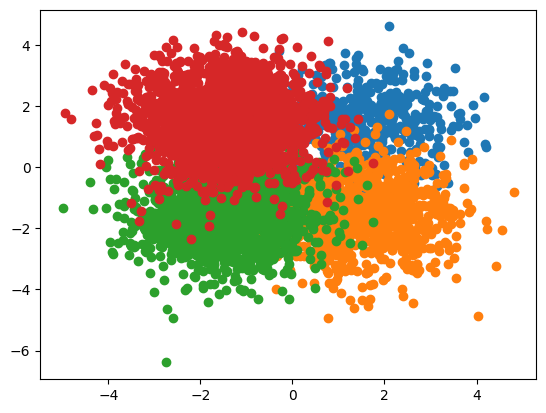

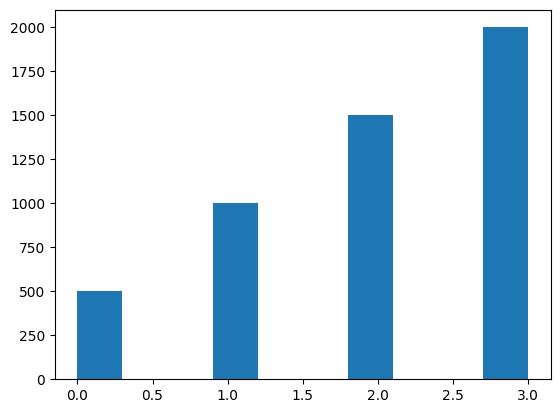

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from misc.metrics import *

samples_0 = torch.randn(500,2)+torch.tensor([1.5,1.5])
samples_1 = torch.randn(1000,2)+torch.tensor([1.5,-1.5])
samples_2 = torch.randn(1500,2)+torch.tensor([-1.5,-1.5])
samples_3 = torch.randn(2000,2)+torch.tensor([-1.5,1.5])
plt.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy())
plt.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy())
plt.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy())
plt.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy())
plt.show()

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(500), torch.ones(1000), 2*torch.ones(1500), 3*torch.ones(2000)]).long()

plt.hist(labels.numpy())
plt.show()

In [2]:
class LogisticClassifier:
    def __init__(self,samples, labels,mu_beta=None, Sigma_beta=None):
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        if mu_beta is not None:
            self.mu_beta = mu_beta
        else:
            self.mu_beta = torch.zeros((self.sample_dim+1)*self.C)
        if Sigma_beta is not None:
            self.Sigma_beta = Sigma_beta
        else: 
            self.Sigma_beta = torch.eye((self.sample_dim+1)*self.C)   
    
    def sample_beta_from_prior(self,num_samples):
        return torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).sample(num_samples)
    
    def log_prob(self,samples, betas):
        log_prob = -torch.cat([samples, torch.ones(samples.shape[0],1)], dim = -1).unsqueeze(0).repeat(betas.shape[0],1,1)@betas.reshape(betas.shape[0],self.sample_dim+1,self.C)
        return log_prob - torch.logsumexp(log_prob, dim = -1, keepdim =True)
        
    def log_posterior_prob(self,betas):
        return torch.sum(self.log_prob(self.samples, betas)*self.labels.unsqueeze(0).repeat(betas.shape[0],1,1),dim = [-2,-1]) + torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).log_prob(betas)

In [4]:
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
betas = model.sample_beta_from_prior([17])
from markov_chain_monte_carlo import * 
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None, 100)
samples_beta_post = sampler.sample(500,tau=5e-4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.56it/s, acceptance = tensor(0.7900)]


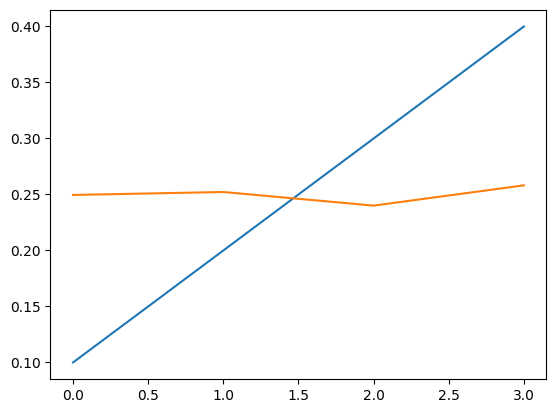

In [5]:
with torch.no_grad():
    plt.plot([500*(1/(500+1000+1500+2000)),1000*(1/(500+1000+1500+2000)),1500*(1/(500+1000+1500+2000)),2000*(1/(500+1000+1500+2000))])
    plt.plot(torch.mean(torch.exp(model.log_prob(torch.randn(10000,2)*50,samples_beta_post)), dim = [0,1]))
    plt.show()